In [1]:
import vizdoom as vzd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
import itertools as it
import skimage.transform

import os
from time import sleep, time
from collections import deque
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
class NeuralNet(nn.Module):
    def __init__(self, available_actions_count):
        super(NeuralNet, self).__init__()
        self.convolutional_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, stride=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=2, bias=False),
            nn.ReLU(),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, bias=False),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, bias=False),
            nn.ReLU()
        )
        self.full_connected_layers = nn.Sequential(
            nn.Linear(192, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
        )

        self.output_layer = nn.Linear(64, available_actions_count)

    def forward(self, x):
        x = self.convolutional_layers(x)
        x = x.view(-1, 192)
        x = self.full_connected_layers(x)
        x = self.output_layer(x)
        return x


In [3]:
class SARSAAgent:
    def __init__(self, action_size, params):
        self.action_size = action_size
        self.batch_size = params['batch_size']
        self.discount = params['discount_factor']
        self.learning_rate = params['learning_rate']
        self.epsilon = params['epsilon']
        self.epsilon_decay = params['epsilon_decay']
        self.epsilon_min = params['epsilon_min']
        self.loss_fn = nn.MSELoss()
        self.device = params['device']

        self.behaviour_policy_net = NeuralNet(action_size).to(self.device)
        self.target_policy_net = NeuralNet(action_size).to(self.device)

        self.optimizer = optim.SGD(self.behaviour_policy_net.parameters(), lr=self.learning_rate)

    def get_action(self, state):
        if np.random.random() < self.epsilon:
            return random.choice(range(self.action_size))
        else:
            state = self.array_to_tensor(state)
            q_values = self.behaviour_policy_net(state)
            action = q_values.max(dim=1)[1].item()
            return action

    def array_to_tensor(self, arr):
        arr = np.expand_dims(arr, axis=0)
        arr = torch.from_numpy(arr).float().to(self.device)
        return arr

    def update_target_policy_net(self):
        self.target_policy_net.load_state_dict(self.behaviour_policy_net.state_dict())

    def update_behaviour_policy_net(self, replay_buffer):
        batch = random.sample(replay_buffer, self.batch_size)
        batch = np.array(batch, dtype=object)

        states = np.stack(batch[:, 0]).astype(float)
        actions = batch[:, 1].astype(int)
        rewards = batch[:, 2].astype(float)
        next_states = np.stack(batch[:, 3]).astype(float)
        next_actions = np.stack(batch[:, 4]).astype(int)
        dones = batch[:, 5].astype(bool)
        not_dones = ~dones

        row_idx = np.arange(self.batch_size)  

        with torch.no_grad():
            next_states = torch.from_numpy(next_states).float().to(self.device)
            idx = row_idx, np.argmax(self.behaviour_policy_net(next_states).cpu().data.numpy(), 1)
            next_state_values = self.target_policy_net(next_states).cpu().data.numpy()[idx]
            next_state_values = next_state_values[not_dones]

        q_targets = rewards.copy()
        q_targets[not_dones] += self.discount * next_state_values
        q_targets = torch.from_numpy(q_targets).float().to(self.device)

        idx = row_idx, actions
        states = torch.from_numpy(states).float().to(self.device)
        action_values = self.behaviour_policy_net(states)[idx].float().to(self.device)

        self.optimizer.zero_grad()
        td_error = self.loss_fn(q_targets, action_values)
        td_error.backward()
        self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        else:
            self.epsilon = self.epsilon_min
        return td_error.item()


        return td_error.item()

In [4]:
def preprocess(img, resolution):
    img = skimage.transform.resize(img, resolution)
    img = img.astype(np.float32)
    img = np.expand_dims(img, axis=0)
    return img


In [5]:
                
def visualize(game, agent, params):
    for _ in range(params['episodes_to_watch']):
        game.new_episode()
        while not game.is_episode_finished():
            state = preprocess(game.get_state().screen_buffer, params['resolution'])
            best_action_index = agent.get_action(state)

            game.set_action(params['actions'][best_action_index])
            for _ in range(params['frame_repeat']):
                game.advance_action()

        sleep(1.0)
        score = game.get_total_reward()
        print("Total score: ", score)

In [6]:
def train_sarsa_agent(game, train_parameters):
    actions = train_parameters['actions']

    # Initialize our agent with the set parameters
    agent = SARSAAgent(len(actions), train_parameters)

    start_time = time()

    time_steps = train_parameters['total_time_steps']
    replay_buffer = deque(maxlen=train_parameters['replay_buffer_size'])

    game.new_episode()
    train_scores = []
    train_loss = []
    global_step = 0

    for _ in trange(time_steps):
        state = preprocess(game.get_state().screen_buffer,
                               train_parameters['resolution'])
        action = agent.get_action(state)
        reward = game.make_action(actions[action], train_parameters['frame_repeat'])
        done = game.is_episode_finished()

        if not done:
            next_state = preprocess(
                game.get_state().screen_buffer, train_parameters['resolution'])
        else:
            next_state = np.zeros((1, 30, 45)).astype(np.float32)

        next_action = agent.get_action(next_state)

        replay_buffer.append((state, action, reward,
                                next_state, next_action, done))

        if global_step > agent.batch_size:
                train_loss.append(agent.update_behaviour_policy_net(replay_buffer))

        if global_step % train_parameters['update_target_interval'] == 0:
            agent.update_target_policy_net()        

        if done:
            train_scores.append(game.get_total_reward())
            game.new_episode()

        global_step += 1

    visualize(game, agent, train_parameters)
    agent.update_target_policy_net()
    train_scores = np.array(train_scores)
    print("Results: mean: %.1f +/- %.1f," % (train_scores.mean(), train_scores.std()),
            "min: %.1f," % train_scores.min(), "max: %.1f," % train_scores.max())

    game.close()
    return agent, game, train_scores, train_loss


In [7]:
def plot_curves(arr_list, legend_list, color_list, ylabel, fig_title):
    """
    Args:
        arr_list (list): list of results arrays to plot
        legend_list (list): list of legends corresponding to each result array
        color_list (list): list of color corresponding to each result array
        ylabel (string): label of the Y axis

        Note that, make sure the elements in the arr_list, legend_list and color_list are associated with each other correctly.
        Do not forget to change the ylabel for different plots.
    """
    # set the figure type
    fig, ax = plt.subplots(figsize=(12, 8))

    # PLEASE NOTE: Change the labels for different plots
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Episodes")

    # ploth results
    h_list = []
    for arr, legend, color in zip(arr_list, legend_list, color_list):
        # compute the standard error
        arr_err = arr.std(axis=0) / np.sqrt(arr.shape[0])
        # plot the mean
        h, = ax.plot(range(arr.shape[1]), arr.mean(axis=0), color=color, label=legend)
        # plot the confidence band
        arr_err *= 1.96
        ax.fill_between(range(arr.shape[1]), arr.mean(axis=0) - arr_err, arr.mean(axis=0) + arr_err, alpha=0.3,
                        color=color)
        # save the plot handle
        h_list.append(h)

    # plot legends
    ax.set_title(f"{fig_title}")
    ax.legend(handles=h_list)

    plt.show()


In [8]:
if __name__ == '__main__':

    print("Initializing doom...")
    game = vzd.DoomGame()
    game.load_config(os.path.join(vzd.scenarios_path, "basic.cfg"))
    game.set_window_visible(False)
    game.set_mode(vzd.Mode.PLAYER)
    game.set_screen_format(vzd.ScreenFormat.GRAY8)
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)
    game.init()
    print("Doom initialized.")

    n = game.get_available_buttons_size()
    actions = [list(a) for a in it.product([0, 1], repeat=n)]

    train_parameters = {
        'learning_rate': 0.00025,
        'discount_factor': 0.99,
        'total_time_steps': 10000,
        'replay_buffer_size': 10000,
        'update_target_interval': 2000,
        'batch_size': 64,
        'frame_repeat': 12,
        'resolution': (30, 45),
        'episodes_to_watch': 5,
        'model_savefile': "./model-doom.pth",
        'device': torch.device('cuda'),
        'epsilon': 1,
        'epsilon_decay': 0.9996,
        'epsilon_min': 0.1,
        'actions': actions
    }

    agent, game, returns, loss = train_sarsa_agent(game, train_parameters)

    game.close()
    game.set_window_visible(True)
    game.set_mode(vzd.Mode.ASYNC_PLAYER)
    game.init()

    visualize(game, agent, train_parameters)
    game.close()


Initializing doom...
Doom initialized.


100%|██████████| 10000/10000 [08:01<00:00, 20.76it/s]


Total score:  64.0
Total score:  95.0
Total score:  71.0
Total score:  47.0
Total score:  95.0
Results: mean: -3.8 +/- 156.4, min: -410.0, max: 95.0,
Total score:  94.0
Total score:  70.0
Total score:  82.0
Total score:  94.0
Total score:  58.0


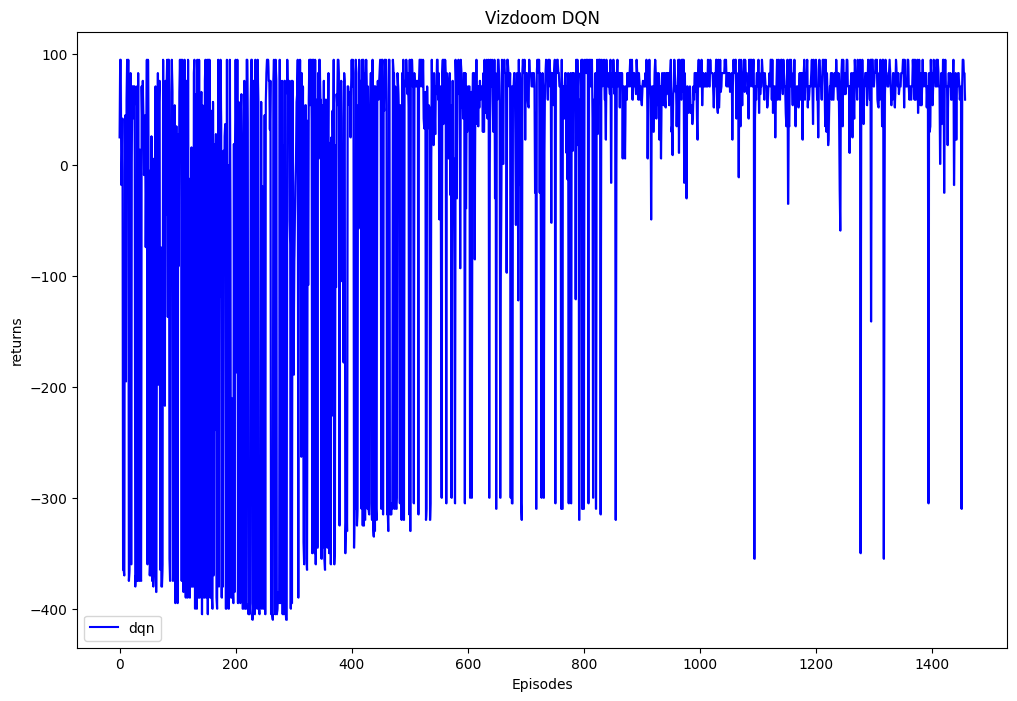

In [11]:
plot_curves([np.array([returns])], ['dqn'], ['b'], 'returns', 'Vizdoom DQN')

In [10]:
game.set_window_visible(True)
game.set_mode(vzd.Mode.ASYNC_PLAYER)
game.init()

visualize(game, agent, train_parameters)
game.close()

Total score:  70.0
Total score:  58.0
Total score:  82.0
Total score:  70.0
Total score:  29.0
